## Import Libraries

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report
import librosa
import IPython.display as ipd
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm

## Import `.csv` file

In [110]:
data = pd.read_csv('D:\Programming\Machine Learning\Datasets\Sound classification\sound_classification_esc50\esc50.csv')
data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


## Data preprocessing

In [111]:
data.isnull().sum()

filename    0
fold        0
target      0
category    0
esc10       0
src_file    0
take        0
dtype: int64

In [113]:
data.duplicated().sum()

0

In [3]:
data.drop(columns = ['esc10', 'src_file', 'take', 'fold'], inplace=True)

In [4]:
data.sample(5)

,filename,target,category
1575,4-234879-A-6.wav,6,hen
1087,3-166125-A-23.wav,23,breathing
1226,4-125072-A-19.wav,19,thunderstorm
1119,3-181278-A-22.wav,22,clapping
857,3-118069-A-27.wav,27,brushing_teeth


In [5]:
label = dict(zip(data['target'], data['category']))
print(label)

{0: 'dog', 14: 'chirping_birds', 36: 'vacuum_cleaner', 19: 'thunderstorm', 30: 'door_wood_knock', 34: 'can_opening', 9: 'crow', 22: 'clapping', 48: 'fireworks', 41: 'chainsaw', 47: 'airplane', 31: 'mouse_click', 17: 'pouring_water', 45: 'train', 8: 'sheep', 15: 'water_drops', 46: 'church_bells', 37: 'clock_alarm', 32: 'keyboard_typing', 16: 'wind', 25: 'footsteps', 4: 'frog', 3: 'cow', 27: 'brushing_teeth', 43: 'car_horn', 12: 'crackling_fire', 40: 'helicopter', 29: 'drinking_sipping', 10: 'rain', 7: 'insects', 26: 'laughing', 6: 'hen', 44: 'engine', 23: 'breathing', 20: 'crying_baby', 49: 'hand_saw', 24: 'coughing', 39: 'glass_breaking', 28: 'snoring', 18: 'toilet_flush', 2: 'pig', 35: 'washing_machine', 38: 'clock_tick', 21: 'sneezing', 1: 'rooster', 11: 'sea_waves', 42: 'siren', 5: 'cat', 33: 'door_wood_creaks', 13: 'crickets'}


In [6]:
data['category'].value_counts()

category
dog                 40
glass_breaking      40
drinking_sipping    40
rain                40
insects             40
laughing            40
hen                 40
engine              40
breathing           40
crying_baby         40
hand_saw            40
coughing            40
snoring             40
chirping_birds      40
toilet_flush        40
pig                 40
washing_machine     40
clock_tick          40
sneezing            40
rooster             40
sea_waves           40
siren               40
cat                 40
door_wood_creaks    40
helicopter          40
crackling_fire      40
car_horn            40
brushing_teeth      40
vacuum_cleaner      40
thunderstorm        40
door_wood_knock     40
can_opening         40
crow                40
clapping            40
fireworks           40
chainsaw            40
airplane            40
mouse_click         40
pouring_water       40
train               40
sheep               40
water_drops         40
church_bells        40
cl

## Observing random audio files

Selected category: Crow


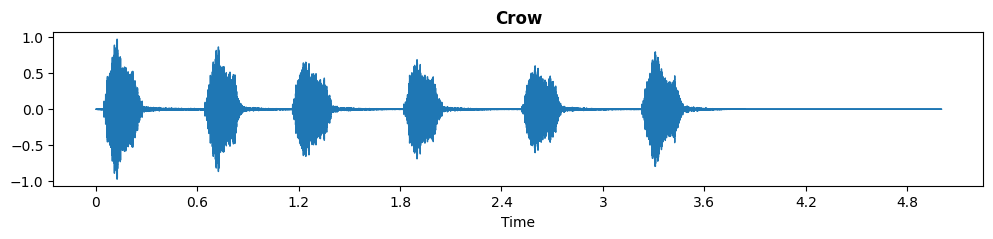

In [7]:
plt.figure(figsize = (12, 2))

dest_file_path = r'D:\Programming\Machine Learning\Datasets\Sound classification\sound_classification_esc50\audio\audio'
rand_data = data.sample(1)
rand_category = rand_data['category'].values[0].replace("_", " ").title()
rand_audio_path = rand_data['filename'].to_numpy()[0]
audio_file_path = os.path.join(dest_file_path, rand_audio_path)   # Default sampling rate is 22050
print(f"Selected category: {rand_category}")
audio, samp_rate = librosa.load(audio_file_path, mono = True)
librosa.display.waveshow(audio, sr = samp_rate)
plt.title(rand_category, fontweight = 'bold')
ipd.Audio(audio_file_path)

## Preparing the data 

In [8]:
def get_data(num_mfcc = 64):
    global dest_file_path
    X = []
    y = []
    for _, filename, target, _ in tqdm(data.itertuples(), desc = "Generating your data"):
        loaded_audio, _ = librosa.load(os.path.join(dest_file_path, filename))
        mfcc_audio = librosa.feature.mfcc(y = loaded_audio, n_mfcc = num_mfcc)
        mfcc_audio = np.mean(mfcc_audio.T, axis = 0)
        X.append(mfcc_audio)
        y.append(target)
    return np.array(X), np.array(y)

In [9]:
X, y = get_data()

Generating your data:: 2000it [00:16, 122.53it/s]


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

- Using `tf.data` API for converting `np.array` to `tf.data.Dataset` and prefetching it for faster training!

In [11]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size = 32).prefetch(tf.data.AUTOTUNE)
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size = 32).prefetch(tf.data.AUTOTUNE)

## Modelling experiments

- setting up the `ModelCheckPoint` callback

In [12]:
def model_ckpt(model_name):
    return ModelCheckpoint(
        filepath = f'./{model_name}.keras',
        monitor = 'val_accuracy',
        save_best_only = True
    )


In [43]:
model = Sequential()
model.add(Dense(units = 64, activation = 'relu', input_shape = (64, )))
model.add(Dense(units = 128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.5))

model.add(Dense(units = len(label), activation = 'softmax'))

In [44]:
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [45]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 128)               8320      
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 50)                6450      
                                                                 
Total params: 19442 (75.95 KB)
Trainable params: 19186 (74.95 KB)
Non-trainable params: 256 (1.00 KB)
__________________

In [46]:
model_hist = model.fit(train_data, validation_data = test_data, epochs = 150, callbacks = [model_ckpt("model_new")])

Epoch 1/150
50/50 [==============================] - 1s 4ms/step - loss: 4.3286 - accuracy: 0.0388 - val_loss: 4.1286 - val_accuracy: 0.0525
Epoch 2/150
50/50 [==============================] - 0s 2ms/step - loss: 3.7706 - accuracy: 0.0812 - val_loss: 3.3705 - val_accuracy: 0.1275
Epoch 3/150
50/50 [==============================] - 0s 2ms/step - loss: 3.5205 - accuracy: 0.1100 - val_loss: 3.1579 - val_accuracy: 0.1900
Epoch 4/150
50/50 [==============================] - 0s 2ms/step - loss: 3.3316 - accuracy: 0.1338 - val_loss: 3.0678 - val_accuracy: 0.2075
Epoch 5/150
50/50 [==============================] - 0s 2ms/step - loss: 3.1957 - accuracy: 0.1587 - val_loss: 3.0091 - val_accuracy: 0.2025
Epoch 6/150
50/50 [==============================] - 0s 2ms/step - loss: 3.0343 - accuracy: 0.1863 - val_loss: 2.9670 - val_accuracy: 0.2125
Epoch 7/150
50/50 [==============================] - 0s 2ms/step - loss: 2.9377 - accuracy: 0.2062 - val_loss: 2.9067 - val_accuracy: 0.2675
Epoch 8/150
5

## Evaluating Model Performance

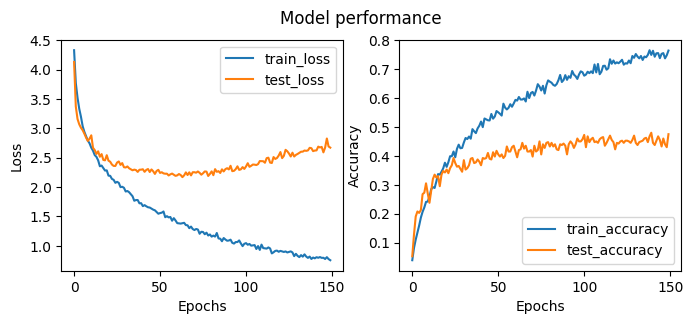

In [107]:
plt.figure(figsize = (8, 3))
plt.subplot(1, 2, 1)
sns.lineplot(x = model_hist.epoch, y = model_hist.history['loss'], label = "train_loss")
sns.lineplot(x = model_hist.epoch, y = model_hist.history['val_loss'], label = 'test_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
sns.lineplot(x = model_hist.epoch, y = model_hist.history['accuracy'], label = "train_accuracy")
sns.lineplot(x = model_hist.epoch, y = model_hist.history['val_accuracy'],label = "test_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.suptitle("Model performance");


- Loading the best model

In [121]:
loaded_model = tf.keras.models.load_model('./model_new.keras')

In [122]:
loaded_model.evaluate(test_data)

13/13 [==============================] - 0s 1ms/step - loss: 2.6113 - accuracy: 0.4800


[2.6112918853759766, 0.47999998927116394]

- getting predictions on test data

In [74]:
y_pred = np.argmax(loaded_model.predict(X_test), axis = 1)

13/13 [==============================] - 0s 800us/step


- evaluating by classification metrics such as `accuracy`, `recall`, `precision` and `f1_score`

In [75]:
print(f"Accuracy score: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision score: {precision_score(y_test, y_pred, average = 'macro'):.3f}")
print(f"Recall score: {recall_score(y_test, y_pred, average = 'macro'):.3f}")
print(f"F1 score: {f1_score(y_test, y_pred, average = 'macro'):.3f}")

Accuracy score: 0.480
Precision score: 0.494
Recall score: 0.478
F1 score: 0.463


- generating classification_report

In [76]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.50      0.53         8
           1       0.55      0.75      0.63         8
           2       0.57      0.40      0.47        10
           3       0.56      0.62      0.59         8
           4       0.58      0.70      0.64        10
           5       1.00      0.14      0.25         7
           6       0.33      0.60      0.43         5
           7       0.53      0.80      0.64        10
           8       0.44      0.44      0.44         9
           9       1.00      0.75      0.86        12
          10       0.25      0.38      0.30         8
          11       1.00      0.57      0.73         7
          12       0.75      0.69      0.72        13
          13       0.67      0.44      0.53         9
          14       0.38      0.43      0.40         7
          15       0.33      0.33      0.33         9
          16       0.55      0.60      0.57        10
          17       0.00    

#### Confusion Matrix

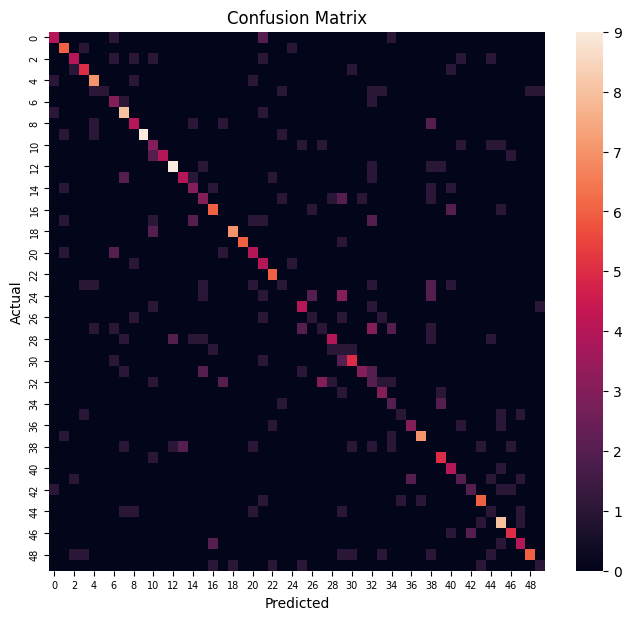

In [84]:
plt.figure(figsize = (8, 7))
sns.heatmap(confusion_matrix(y_test, y_pred))
plt.title("Confusion Matrix")
plt.xticks(fontsize = 7)
plt.yticks(fontsize = 7)
plt.xlabel("Predicted")
plt.ylabel("Actual");

## Predicting on a random audio file

In [145]:
random_data = data.sample(1)
audio_path = os.path.join(dest_file_path, random_data['filename'].values[0])
actual_category = random_data['category'].values[0]

audio_file, _ = librosa.load(audio_path)
mfcc_audio = librosa.feature.mfcc(y = audio_file, n_mfcc = 64)
mfcc_audio = np.mean(mfcc_audio.T, axis = 0)

pred = loaded_model.predict(mfcc_audio.reshape(1, -1), verbose=0)
pred = np.argmax(pred, axis = 1)
predicted_category = label[pred[0]]

print(f"Actual category: {actual_category}")
print(f"Predicted category: {predicted_category}")
ipd.Audio(audio_path)


Actual category: sheep
Predicted category: sheep


<h5 text-align='center'>&copy; Mainak Mukherjee </p>
<h6><i>Created on: 21/02/2024</i></h6>